In [ ]:
#file: galaxymorphology_imageclassification_vgg16transferlearn.ipynb
#poc: mlr7
#data created: oct_2021
#last modified: april_2022

### Imports

In [1]:
%matplotlib inline

# numeric and data wrangling
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

# deep learning
import tensorflow as tf
print('TensorFlow version: ' + tf.__version__)  # 2.7.0

from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow import keras
from tensorflow.keras import layers

TensorFlow version: 2.7.0


### Data ingest

In [2]:
new_base_dir = './data_galaxy/'

#### Class 0: Smooth Galaxies

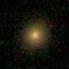

In [3]:
display.Image(new_base_dir + 'train/0_smooth/0_Smooth-Completely-round_0.jpg')

#### Class 1: Spiral Galaxies

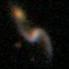

In [4]:
display.Image(new_base_dir + 'train/1_spiral/1_Disk, Face-on, Loose Spiral_1.jpg')

#### Create datasets for DNN training and validation

In [5]:
train_dataset = image_dataset_from_directory(
    #new_base_dir / "train",
    new_base_dir + "/train/",
    #image_size=(180, 180),
    image_size=(69, 69),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    #new_base_dir / "validation",
    new_base_dir  + "/validation/",
    #image_size=(180, 180),
    image_size=(69, 69),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    #new_base_dir / "test",
    new_base_dir + "/test/",
    #image_size=(180, 180),
    image_size=(69, 69),
    batch_size=32)

Found 2036 files belonging to 2 classes.
Found 1014 files belonging to 2 classes.
Found 2042 files belonging to 2 classes.


### Verify compute resources availability

In [6]:
# Verify GPU availability and details

import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

2.7.0
 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  Quadro T2000 || GPU || 2.1 GiB


### Transfer learning, VGG16 base

In [7]:
## VGG16

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    
    #input_shape=(180, 180, 3))
    input_shape=(69, 69, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 69, 69, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 69, 69, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 69, 69, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 34, 34, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 34, 34, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 34, 34, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 17, 17, 128)       0     

In [8]:
## EfficientNet

#conv_base_efficientnet = keras.applications.EfficientNetB0(
#    weights="imagenet",
#    include_top=False,
#    input_shape=(180, 180, 3))

#conv_base_efficientnet.summary()

In [9]:
def get_features_and_labels(dataset):
    '''
    Utility function from Chollet
    '''
    all_features = []
    all_labels = []
    for images, labels in dataset:
        
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        
        #preprocessed_images = keras.applications.efficientnet.preprocess_input(images) # figure this out
        #features = conv_base_efficientnet.predict(preprocessed_images)
        
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [10]:
%%time

#print('EfficientNetB0 Base:')
print('VGG16 Base:')

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

## VGG16 Base: (180x180)
## Wall time: 1min 22s

# Galaxy10:, 69x69
#VGG16 Base:
#Wall time: 24.1 s

VGG16 Base:
Wall time: 21.9 s


In [11]:
train_features.shape

(2036, 2, 2, 512)

## Build new classifier (dense network)

In [12]:
#inputs = keras.Input(shape=(6,6,1280))
#inputs = keras.Input(shape=(5, 5, 512))

inputs = keras.Input(shape=(2, 2, 512))

x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

### Train new network

In [14]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
64/64 [==============================] - 2s 19ms/step - loss: 2.2518 - accuracy: 0.8924 - val_loss: 1.0282 - val_accuracy: 0.9310
Epoch 2/20
64/64 [==============================] - 0s 6ms/step - loss: 1.3079 - accuracy: 0.9244 - val_loss: 0.5037 - val_accuracy: 0.9586
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 0.9040 - accuracy: 0.9420 - val_loss: 0.5272 - val_accuracy: 0.9566
Epoch 4/20
64/64 [==============================] - 0s 6ms/step - loss: 0.7923 - accuracy: 0.9396 - val_loss: 0.3441 - val_accuracy: 0.9645
Epoch 5/20
64/64 [==============================] - 0s 6ms/step - loss: 0.6609 - accuracy: 0.9543 - val_loss: 0.6950 - val_accuracy: 0.9487
Epoch 6/20
64/64 [==============================] - 0s 6ms/step - loss: 0.5010 - accuracy: 0.9597 - val_loss: 0.5982 - val_accuracy: 0.9527
Epoch 7/20
64/64 [==============================] - 0s 6ms/step - loss: 0.5159 - accuracy: 0.9592 - val_loss: 0.3852 - val_accuracy: 0.9625
Epoch 8/20
64/64 [=

### Viz results

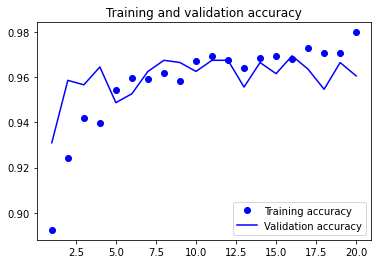

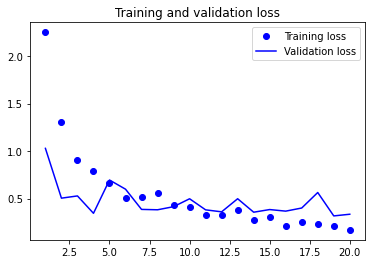

In [15]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Achieve 0.96 validation accuracy on the galaxy morphology binary classification dataset, utilizing a transfer learning strategy with a VGG16 base. 